# Data set overview

## Overview the Data Set and preprocessing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing,
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

In [2]:
import cv2 as cv

def read_image(file):
        img = cv.imread(file)
        img = cv.resize(img, (64, 64))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = img.astype("float32")/255
        return img

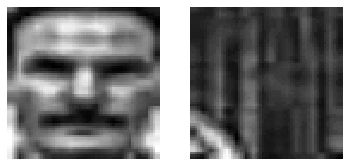

In [3]:
# Pre processing the dataset
face_list = []
for filename in glob.glob("face_detection_data/face/*.png"):
    img = read_image(filename)
    face_list.append(img)

non_face_list = []   
for filename in glob.glob("face_detection_data/non-face/*.png"):
    img = read_image(filename)
    non_face_list.append(img)

plt.subplot(1, 2, 1)
plt.imshow(face_list[50], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(non_face_list[0], cmap="gray")
plt.axis("off")
plt.show()

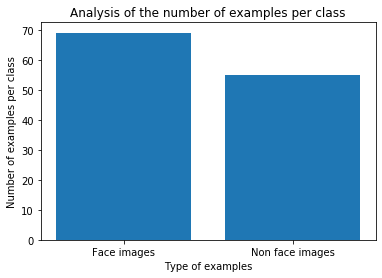

In [4]:
plt.bar(["Face images","Non face images"], [len(face_list), len(non_face_list)])
plt.ylabel("Number of examples per class")
plt.xlabel("Type of examples")
plt.title("Analysis of the number of examples per class")
plt.show()

## Data Augmentation

In [5]:
# example of horizontal flip image augmentation
flipped_face_images = []
for face_img in face_list:
	flipped_face_img = cv.flip(face_img, flipCode=1)
	flipped_face_images.append(flipped_face_img)

flipped_non_face_images = []
for non_face_img in non_face_list:
	flipped_non_face_img = cv.flip(non_face_img, flipCode=1)
	flipped_non_face_images.append(flipped_non_face_img)

face_list.extend(flipped_face_images)
non_face_list.extend(flipped_non_face_images)

y_face_list = np.ones(len(face_list))
print(len(face_list))
y_non_face_list = np.zeros(len(non_face_list))

138


## Create full dataset

In [6]:
full_dataset = []
full_dataset.extend(face_list)
full_dataset.extend(non_face_list)
print(len(full_dataset))

248


## HOG Feature Extraction

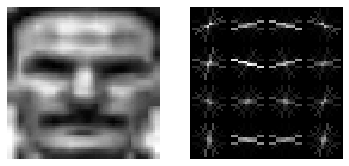

In [7]:
from skimage.feature import hog
import random
from sklearn.utils import shuffle

full_dataset_y = np.append(y_face_list, y_non_face_list, 0)

ppc = 16
hog_images = []
hog_features = []

for image in full_dataset:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

plt.subplot(1, 2, 1)
plt.imshow(full_dataset[50], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(hog_images[50], cmap="gray")
plt.axis("off")
plt.show()

In [9]:
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import classification_report,accuracy_score

labels =  full_dataset_y.reshape(len(full_dataset_y), 1)

clf = svm.SVC()
hog_features = np.array(hog_features)

x_train, x_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2)


#clf.fit(x_train, y_train)

## Without K fold cross validation

In [16]:
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import classification_report,accuracy_score

labels =  full_dataset_y.reshape(len(full_dataset_y), 1)

clf = svm.SVC()
hog_features = np.array(hog_features)

x_train, X_b, y_train, Y_b = train_test_split(hog_features, labels, test_size=0.40)
x_test, x_val, y_test, y_val = train_test_split(X_b, Y_b, test_size=0.50)


#clf.fit(x_train, y_train)

In [22]:
def dataset3ParamsWithoutKfold(X, y, Xval,yval,vals):
    """
    dataset3Params returns the optimal C and gamma(1/sigma) based on a cross-validation set.
    """
    acc = 0
    best_C=0
    best_gamma=0
    score_history=[]
    c_history=[]
    gamma_history=[]
    for i in vals:
        C= i
        for j in vals:
            gamma = 1/j
            classifier = svm.SVC(C=C,gamma=gamma)
            classifier.fit(X,y)
            score = classifier.score(Xval,yval)
            #score_history.append(score)
            #c_history.append(C)
            #gamma_history.append(gamma)
            if score>acc:
                acc =score
                best_C =C
                best_gamma=gamma

    return best_C, best_gamma, score_history, c_history, gamma_history

In [23]:
vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_gamma, score_history, c_history,gamma_history = dataset3ParamsWithoutKfold(x_train, y_train, x_val,y_val,vals)


#What are the best C and sigma ?
print("Best C: "+str(best_C))
print("Best gamma: "+str(best_gamma))


#Build an SVM classifier with the best C and gamma and get classifier score of about 95% ?
classifier = svm.SVC(gamma=best_gamma,C=best_C, kernel="rbf")
X_Train_new=np.concatenate((x_train,x_val),axis=0)
Y_Train_new=np.concatenate((y_train,y_val),axis=0)
classifier.fit(X_Train_new,Y_Train_new)
print(classifier.score(x_test,y_test))  #ANSWER arround 98% accuracy

Best C: 30
Best gamma: 0.1
1.0


In [24]:
y_pred = classifier.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        45
         1.0       1.00      1.00      1.00        54

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



## With K fold cross validation

In [8]:
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import classification_report,accuracy_score

labels =  full_dataset_y.reshape(len(full_dataset_y), 1)

clf = svm.SVC()
hog_features = np.array(hog_features)

x_train, x_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.20)

#clf.fit(x_train, y_train)

In [11]:
def dataset3Params(X, y, splits,vals):
    """
    dataset3Params returns the optimal C and gamma(1/sigma) based on a cross-validation set.
    """
    acc = 0
    best_C=0
    best_gamma=0
    score_history=[]
    
    parameeter_history=[]
    for i in vals:
        C= i
        for j in vals:
            gamma = 1/j
            classifier = svm.SVC(C=C,gamma=gamma, kernel="rbf")
            kfold = KFold(n_splits=5,shuffle=True)
            scores = cross_val_score(classifier, X, y, cv=kfold)
            score = scores.mean()
            score_history.append(score)
            parameeter_history.append(str((C,gamma)))
            if score>acc:
                acc =score
                best_C =C
                best_gamma=gamma

    plt.figure(num=1,figsize=(15,8),dpi=1200)
    plt.rcParams.update({"font.size":12})
    plt.plot(parameeter_history,score_history,label="cross validation accuracy")
    plt.xlabel("Training examples (C,Gamma) ")
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy")
    plt.ylim([0, 1.05])
    plt.legend(loc='lower right')
    plt.title(f"K-Fold with {splits} splits")
    plt.show()

    return best_C, best_gamma

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_gamma = dataset3Params(x_train, y_train, 5,vals)


#What are the best C and sigma ?
print("Best C: "+str(best_C))
print("Best gamma: "+str(best_gamma))

#Build an SVM classifier with the best C and gamma and get classifier score of about 95% ?
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(50):
    classifier = svm.SVC(gamma=best_gamma,C=best_C, kernel="rbf")
    classifier.fit(x_train,y_train)

    y_pred = classifier.predict(x_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    precision_scores.append(precision_score(y_test, y_pred, average="macro"))
    recall_scores.append(recall_score(y_test, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print(f"F1 score: {sum(f1_scores)/len(f1_scores)}\n")
print(f"Precision score: {sum(precision_scores)/len(precision_scores)}\n")
print(f"Recall score: {sum(recall_scores)/len(recall_scores)}\n")
print(f"Accuracy score: {sum(accuracy_scores)/len(accuracy_scores)}\n")


     

Best C: 30
Best gamma: 1.0
F1 score: 1.0

Precision score: 1.0

Recall score: 1.0

Accuracy score: 1.0



In [29]:
y_pred = classifier.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00        59

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



# PROJETCT 1

In [10]:



# Join a sequence of arrays along an row axis.
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) # from 0 to 204 is zero sign and from 205 to 410 is one sign 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0], 1) # create labels: 0 -> zero sign; 1 -> one sign
#Y_a= np.concatenate((Y_l[204:409], Y_l[822:1027] ), axis=0).reshape(X.shape[0], 1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)


# The shape of the X is (410, 64, 64):
#  - 410 means that we have 410 images (zero and one signs)
#  - 64 means that our image size is 64x64 (64x64 pixels)

# The shape of the Y is (410,1):
#  - 410 means that we have 410 labels (0 and 1)

NameError: name 'x_l' is not defined

In [11]:
# We are going to create a training,test and validation array, 60% - training, 20% - test, 20% - validation
from sklearn.model_selection import train_test_split
X_train, X_b, Y_train, Y_b = train_test_split(X, Y, test_size=0.40, random_state=42)
number_of_train = X_train.shape[0]
X_test, X_val, Y_test, Y_val = train_test_split(X_b, Y_b, test_size=0.50, random_state=42)
number_of_test = X_test.shape[0]
number_of_val = X_val.shape[0]

NameError: name 'X' is not defined

In [12]:
X_train_flatten = X_train.reshape(number_of_train, X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test.reshape(number_of_test, X_test.shape[1]*X_test.shape[2])
X_val_flatten = X_val.reshape(number_of_val, X_val.shape[1]*X_val.shape[2])

print("X train flatten", X_train_flatten.shape)
print("X test flatten", X_test_flatten.shape)
print("X val flatten", X_val_flatten.shape)

NameError: name 'X_train' is not defined

In [13]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
x_val = X_val_flatten.T
y_train = Y_train.T
y_test = Y_test.T
y_val = Y_val.T
print("x train: ", x_train.shape)
print("x test: ", x_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

NameError: name 'X_train_flatten' is not defined

# CNN with Tensorflow

In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

%matplotlib inline
import matplotlib.pyplot as plt
# import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split
import glob
import os
import math
import operator
import functools
import random
import datetime
from scipy.ndimage.interpolation import rotate, shift, zoom

Instructions for updating:
non-resource variables are not supported in the long term


## Loading the data

In [15]:
all_X = np.load('npy_dataset/X.npy')
all_Y = np.load('npy_dataset/Y.npy')
test_size = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size=test_size, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'npy_dataset/X.npy'

In [16]:
print('Training shape:', X_train.shape)
print(X_train.shape[0], 'sample,',X_train.shape[1] ,'x',X_train.shape[2] ,'size grayscale image.')
print('Test shape:', X_test.shape)
print(X_test.shape[0], 'sample,',X_test.shape[1] ,'x',X_test.shape[2] ,'size grayscale image.\n')

NameError: name 'X_train' is not defined

## Preparate the data

In [17]:
img_size_flat=img_size*img_size
train_X = X_train
train_Y = Y_train
new_train_X = train_X.reshape(X_train.shape[0],img_size_flat)
new_test_X = X_test.reshape(X_test.shape[0],img_size_flat)

NameError: name 'img_size' is not defined

In [18]:
print("Training set (images) shape: {shape}".format(shape=new_train_X.shape))
print("Training set (labels) shape: {shape}".format(shape=train_Y .shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=new_test_X.shape))
print("Test set (labels) shape: {shape}".format(shape=Y_test.shape))

print(all_Y.shape)

NameError: name 'new_train_X' is not defined

## Configuration of Neural Network¶


In [19]:
# architecture hyper-parameter
learning_rate = 0.001
training_iters = 40000
batch_size = 16
display_step = 20

n_input = 64*64 # 64x64 image
dropout = 0.75 
num_classes = 10

In [20]:
tf.disable_v2_behavior() 
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
print('Shape of placeholder',x.shape, y.shape)

Shape of placeholder (?, 4096) (?, 10)


In [21]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [22]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [23]:
def conv_net(x, weights, biases, dropout):
    # reshape input to 64x64 size
    x = tf.reshape(x, shape=[-1, 64, 64, 1])
    

    # Convolution layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max pooling
    conv1 = maxpool2d(conv1, k=2)

    # Convolution layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max pooling
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1) # layer
    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [24]:
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]),name='wc1'),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]),name='wc2'),
    'wd1': tf.Variable(tf.random_normal([64 * 64 * 4, 1024]),name='wd1'),
    'out': tf.Variable(tf.random_normal([1024, num_classes]),name='wout')
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]),name='bc1'),
    'bc2': tf.Variable(tf.random_normal([64]),name='bc2'),
    'bd1': tf.Variable(tf.random_normal([1024]),name='bd1'),
    'out': tf.Variable(tf.random_normal([num_classes]),name='bout')
}

In [25]:
# Create the model
model = conv_net(x, weights, biases, keep_prob)
print(model)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
y_true_cls =  tf.argmax(y, 1)
y_pred_cls = tf.argmax(model, 1)
# This is a vector of booleans whether the predicted 
#class equals the true class of each image.
correct_model = tf.equal(y_pred_cls,y_true_cls)
# This calculates the classification accuracy by first type-casting 
#the vector of booleans to floats, so that False becomes 0 and True becomes 1,
#and then calculating the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_model, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("Add_1:0", shape=(?, 10), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [26]:
def getBatch(X, Y, batchSize=16):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input train/test 
    Y --input label train/test
    
    Returns:
    mini_batches -- tuple of synchronous (mini_batch_X, mini_batch_Y)
    
    """
    arrayLength = X.shape[0]
    count = 0 
    
    while count < arrayLength/batchSize:
        random.seed(datetime.datetime.now())
        randstart = random.randint(0, arrayLength-batchSize-1)
#         print(randstart)
        count += 1
        yield (X[randstart:randstart+batchSize], Y[randstart:randstart+batchSize]) 

In [27]:
loss_t = []
steps_t = []
acc_t = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1   
#     Keep training until reach max iterations
    while step * batch_size < training_iters:
        a = getBatch(new_train_X,train_Y, batch_size)
        batch_x, batch_y = next(a)
        #print(batch_x.shape)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        if step % display_step == 0:
            print('*'*15)
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Loss= " + \
                  "{:.3f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            loss_t.append(loss)
            steps_t.append(step*batch_size)
            acc_t.append(acc)
        step += 1
    
   #
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: new_test_X,
                                      y: Y_test,
                                      keep_prob: 1.}))
    
    cls_pred = sess.run(y_pred_cls, feed_dict={x: new_test_X,
                                      y: Y_test,
                                      keep_prob: 1.})

NameError: name 'new_train_X' is not defined

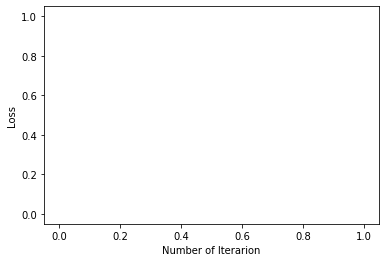

In [28]:
plt.plot(steps_t, loss_t, 'r--')
plt.xlabel("Number of Iterarion")
plt.ylabel("Loss")
plt.show()

In [29]:
print(y_train.shape)
print(cls_pred.shape)

(99, 1)


NameError: name 'cls_pred' is not defined

# CNN with Keras

## Load the data

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os

Using TensorFlow backend.


In [31]:
all_X = np.load('npy_dataset/X.npy')
all_Y = np.load('npy_dataset/Y.npy')
number_of_classes=all_Y.shape[1]

X_train, X_b, Y_train, Y_b = train_test_split(all_X, all_Y, test_size=0.40, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_b, Y_b, test_size=0.50, random_state=42)

X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],1)
X_val=X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1)

FileNotFoundError: [Errno 2] No such file or directory: 'npy_dataset/X.npy'

## Helper functions

In [32]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validation Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validation Accuracy"]=modelHistory.history['val_accuracy']
    
    fig, axarr=plt.subplots(nrows=2, ncols=1 ,figsize=(12,11))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    axarr[0].set_xlabel("Epochs")
    axarr[0].set_ylabel("$J(\Theta)$")
    axarr[0].set_ylim((0,3))
    history[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    axarr[1].set_xlabel("Epochs")
    axarr[1].set_ylabel("Accuracy")
    axarr[1].set_ylim((0,1))
    history[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1]) 
    plt.suptitle(" Convulutional Model {} Loss and Accuracy in Train and Validation Datasets".format(model_name))
    plt.show()

In [33]:
def evaluate_conv_model(model, model_name, X_train, y_train,X_val,y_val, epochs=100,
                        optimizer=optimizers.RMSprop(lr=0.0001), callbacks=None):
    print("[INFO]:Convolutional Model {} created...".format(model_name))
    #X_train, X_test, y_train, y_test = split_dataset(X, y)
    
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    print("[INFO]:Convolutional Model {} compiled...".format(model_name))
    
    print("[INFO]:Convolutional Model {} training....".format(model_name))
    earlyStopping = EarlyStopping(monitor = 'val_loss', patience=20, verbose = 1) 
    if callbacks is None:
        callbacks = [earlyStopping]
        #model.fit()
    modelHistory=model.fit(X_train, y_train, 
             validation_data=(X_val, y_val),
             callbacks=callbacks,
             epochs=epochs,
             verbose=0)
    print("[INFO]:Convolutional Model {} trained....".format(model_name))

    test_scores=model.evaluate(X_val, y_val, verbose=0)
    train_scores=model.evaluate(X_train, y_train, verbose=0)
    print("[INFO]:Train Error:{:.3f}".format(1-train_scores[1]))
    print("[INFO]:Validation Error:{:.3f}".format(1-test_scores[1]))
    print("[INFO]:Train Accuracy:{:.3f} %".format(train_scores[1]*100))
    print("[INFO]:Validation Accuracy:{:.3f} %".format(test_scores[1]*100))
    
    show_model_history(modelHistory=modelHistory, model_name=model_name)
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Conv model 1

In [34]:
def build_conv_model_1():
    model=Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=(3,3),
                           padding="same",
                           activation="relu", 
                           input_shape=(64, 64,1)))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(number_of_classes, activation="softmax"))
        
    return model

In [35]:
trained_models=dict()
model=build_conv_model_1()
trained_model_1=evaluate_conv_model(model=model, model_name=1, X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

#Will be used for serialization
trained_models["model_1"]=(trained_model_1,optimizers.RMSprop(lr=0.0001) )

NameError: name 'number_of_classes' is not defined

When the above graphs are examined, it can be seen that the model has a low training accuracy rate and a lower validation accuracy rate. This means that high bias and high varience, which is too bad for machine learning model. In addition, the zigzags in the validation graph show that the robustness of validation results is very low.

Considering the above evaluations, it would be useful to add a new Convolution layer to the model.

In [36]:
def build_conv_model_2():
    model = Sequential()
    model.add(layers.Convolution2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
       
    model.add(layers.Convolution2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
      
    return model

In [37]:
model=build_conv_model_2()
trained_model_2=evaluate_conv_model(model=model, model_name=2, X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

NameError: name 'X_train' is not defined

When the above graphs are examined, it can be seen that the model has a high training accuracy rate and a lower validation accuracy rate. This means that low bias and high varience. In addition, although the zigzags in the validation chart are reduced, they still exist. It can be assessed that the robustness of validation results is still low.

In view of the above considerations, it is useful to add a new Conv layer or Dropout layer to avoid overfitted the model. First let's add a new Conv layer.

In [38]:
def build_conv_model_3():
    model = Sequential()
    model.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
           
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
        
    return model

In [39]:
model=build_conv_model_3()
trained_model_3=evaluate_conv_model(model=model, model_name=3, X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

NameError: name 'X_train' is not defined

Although the validation accuracy rate has increased, the problem of overfitting of the model still exists. We can assume that adding a new Conv layer is not useful. In addition, although the zigzags in the validation chart are reduced, they still exist. It can be assessed that the robusness of validation results is still low.

Let's try using the Dropout layer, one of the solutions to the problem of overfitting in deep networks.

In [40]:
def build_conv_model_4():
    model = Sequential()
    model.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
       
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [41]:
model=build_conv_model_4()
trained_model_4=evaluate_conv_model(model=model, model_name=4,X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

NameError: name 'X_train' is not defined

Although the validation success accuracy has increased, the problem of overfitting(high variance) of the model still exists.

Let's try adding a new Conv ==> MaxPool ==> Dropout layer.

In [42]:
def build_conv_model_5():
    model = Sequential()
    model.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
       
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
        
    return model

In [43]:
model=build_conv_model_5()
trained_model_5=evaluate_conv_model(model=model, model_name=5,X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

NameError: name 'X_train' is not defined

Overfitting and low robustness problems were resolved, but the training and validation performance of the model could be better. Let's remove the last Conv ==> MaxPool ==> Dropout layer added to Model 4 and try different things.

We can fine tunne another parameters to improve model performance. It is better to use Dropout layers between full connected layers and perhaps after pooling layers. We can also increase the number of nodes 128 to 256 in full connected layers.

In [44]:
def build_conv_model_6():
    model = Sequential()
    model.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
        
    return model

In [45]:
model=build_conv_model_6()
trained_model_6=evaluate_conv_model(model=model, model_name=6, X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

NameError: name 'X_train' is not defined

Beside,overfitting and low robustness problems were resolved, the training and validation performance of the model lifted up.

We can also fine tunne the number of filters in Conv layers. Filters are the feature detectors. Generally fewer filters are used at the input layer and increasingly more filters used at deeper layers.

Filter size is another parameter we can fine tunne it. The filter size should be as small as possible, but large enough to see features in the input data. It is common to use 3x3 on small images and 5x5 or 7x7 and more on larger image sizes.

BatchNormalization is another layer can be used in CNN. Although the BatchNormalization layer prolongs the training time of deep networks, it has a positive effect on the results. Let's add the BatchNormalization layer to Model 4 and see the results.

In [46]:
def build_conv_model_7():
    model = Sequential()
    model.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
        
    return model

In [47]:
model=build_conv_model_7()
trained_model_7=evaluate_conv_model(model=model, model_name=7, X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

NameError: name 'X_train' is not defined

As we expect BatchNormalization increase the model performans. But there is overfitting problem in the model. To deal with that we will use Dropout layer in Conv blocks.

In [48]:
def build_conv_model_8():
    model = Sequential()
    model.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
        
    return model

In [49]:
model=build_conv_model_8()
trained_model_8_1=evaluate_conv_model(model=model, model_name=8, X_train=X_train, y_train=Y_train,X_val=X_val,y_val=Y_val)

NameError: name 'X_train' is not defined

Model 8 has the best CV error, so we are going to train it with the CV set plus the Train set and test it with the Test Set

In [50]:
X_Train_new=np.concatenate((X_train,X_val),axis=0)
Y_Train_new=np.concatenate((Y_train,Y_val),axis=0)

print(Y_Train_new.shape)
print(X_Train_new.shape)
trained_model_8_final=evaluate_conv_model(model=model, model_name=8, X_train=X_Train_new, y_train=Y_Train_new,X_val=X_test,y_val=Y_test)

NameError: name 'X_train' is not defined

In [51]:
def plot_confusion_matrix(cls_pred,Y_test_cls,num_classes):

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = Y_test_cls
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

In [52]:
epochs=100
earlyStopping = EarlyStopping(monitor = 'val_loss', patience=20, verbose = 1) 
callbacks = [earlyStopping]

y_pred=trained_model_8_final.predict(X_test,callbacks=callbacks,verbose=0)

cls_pred=np.argmax(y_pred,axis=1)
Y_test_cls = np.argmax(Y_test, axis=1)

plot_confusion_matrix(cls_pred=cls_pred,Y_test_cls=Y_test_cls,num_classes=number_of_classes)


NameError: name 'trained_model_8_final' is not defined

In [53]:
def plot_images(images, cls_true, cls_pred=None):
    
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    print(len(axes.flat))

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((64, 64)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "Img {0} \n True: {1}".format(i,cls_true[i])
        else:
            xlabel = "Img {0} \n True: {1}, Pred: {2}".format(i,cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [54]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images =X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = Y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [55]:
correct = (Y_test_cls == cls_pred)

plot_example_errors(cls_pred,correct)

NameError: name 'Y_test_cls' is not defined